In [1]:
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
from skimage.io import imsave
from skimage.transform import resize
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
from skimage.util import crop
from skimage.io import imsave, imread
from scipy.ndimage import binary_fill_holes
import time

sys.path.append('../src')
import unet7

In [2]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_cols = 1392
img_rows = 1040
model_dir = '../data'
start_lr = 1e-4
target_width = 256
target_height = 192

upscale_factor_width = img_cols / target_width
upscale_factor_height = img_cols / target_height

In [3]:
def checkDir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
def read_imgs(dir, img_rows, img_cols):
    images = [f for f in os.listdir(dir) if f.endswith('.tif')]
    imgs = np.ndarray((len(images), img_rows, img_cols, 1), dtype=np.float)
    for idx, img in enumerate(images):
        #print(idx)
        img = imread(os.path.join(dir, img), as_gray=True)
        img = np.expand_dims(img, axis=-1)
        imgs[idx] = img
    return imgs


def read_imgs_masks(img_dir, mask_dir, img_rows, img_cols,
                    target_width=target_width, target_height=target_height):
    images = [f for f in os.listdir(img_dir) if f.endswith('.tif')]
    imgs = np.ndarray((len(images), target_height, target_width, 1), dtype=np.float)
    masks = np.ndarray((len(images), target_height, target_width, 1), dtype=np.float)
    for idx, img in enumerate(images):
        #print(idx)
        msk = img.replace('.tif', '_Simple Segmentation.tif')
        img = imread(os.path.join(img_dir, img), as_gray=True)
        img = resize(img, (target_height, target_width))
        img = np.expand_dims(img, axis=-1)
        imgs[idx] = img
        
        mask = imread(os.path.join(mask_dir, msk), as_gray=True)
        mask = resize(mask, (target_height, target_width))
        mask = np.expand_dims(mask, axis=-1)
        masks[idx] = mask
    return imgs, masks



In [4]:
training_img_dir = os.path.join(model_dir,'train','img')
training_mask_dir = os.path.join(model_dir,'train','mask')
test_img_dir = os.path.join(model_dir,'test','img')
test_mask_dir = os.path.join(model_dir,'test','mask')

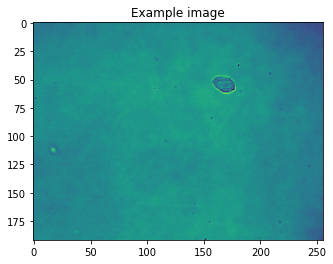

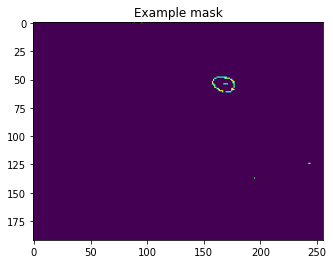

In [5]:
# load training images

training_imgs, training_masks= read_imgs_masks(training_img_dir, training_mask_dir, img_rows, img_cols)
plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(training_imgs[0]))

training_imgs = training_imgs.astype('float32')
training_imgs = training_imgs / training_imgs.max()

training_masks = training_masks.astype('float32')
training_masks = np.where(training_masks > 0.5, 1, 0)

plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(training_masks[0]))

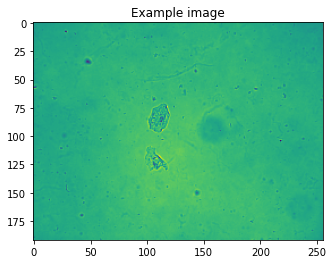

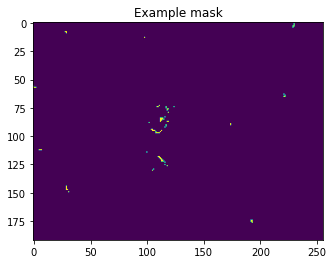

In [6]:
test_imgs, test_masks= read_imgs_masks(test_img_dir, test_mask_dir, img_rows, img_cols)
plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(test_imgs[0]))

test_imgs = test_imgs.astype('float32')
test_imgs = test_imgs / test_imgs.max()

test_masks = test_masks.astype('float32')
test_masks = np.where(test_masks > 0.5, 1, 0)

plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(test_masks[0]))

In [7]:
training_imgs.shape

(7, 192, 256, 1)

#### Pad images and redefine the network target size

Images coming to the U-Net have to be square, rather than rectangular. To ensure this is the case we will pad the rows of the image with a dynamically calculated amount. Please note that to avoid rounding error it is important that the difference between your width and heights is divisible by 2, as equal number of rows will be added to the bottom and top of the image.

In [8]:
# pad images to fit the network

pad_by = int((target_width - target_height) / 2)

training_imgs = np.pad(training_imgs, [(0, 0), (pad_by, pad_by), (0, 0), (0, 0)],
                                       mode='constant', constant_values=0)
training_masks = np.pad(training_masks, [(0, 0), (pad_by, pad_by), (0, 0), (0, 0)],
                                       mode='constant', constant_values=0)

test_imgs = np.pad(test_imgs, [(0, 0), (pad_by, pad_by), (0, 0), (0, 0)],
                                       mode='constant', constant_values=0)
test_masks = np.pad(test_masks,[(0, 0), (pad_by, pad_by), (0, 0), (0, 0)],
                                       mode='constant', constant_values=0)

img_cols = training_imgs.shape[1]
img_rows = training_imgs.shape[2]

print(f'image s were padded by {pad_by}'
      f' and the final width is: {training_imgs.shape[1]}'
      f' and height is {training_imgs.shape[2]}'
       '\nNB:if images are not square - correct or rerun')

image s were padded by 32 and the final width is: 256 and height is 256
NB:if images are not square - correct or rerun


In [9]:
np.savez('../data/small_res_dataset_sample.npz', training_imgs=training_imgs,
                                 training_masks=training_masks,
                                 test_imgs=test_imgs,
                                 test_masks=test_masks)

In [10]:
training_imgs.shape

(7, 256, 256, 1)